In [209]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [210]:
def f(x):
    return 3*x**2 -4*x + 5

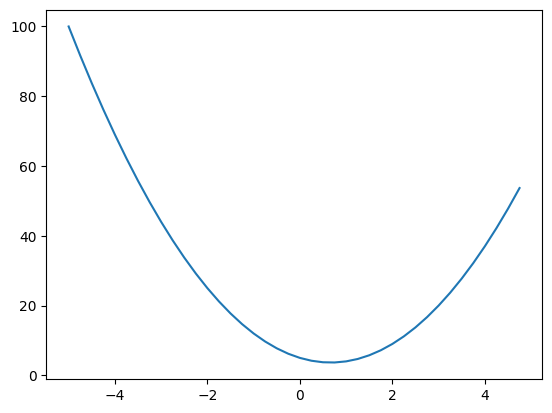

In [211]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [212]:
# simple derivative
h = 0.0001
x = 3
(f(x+h) - f(x))/h 

14.000300000063248

In [213]:
# more complex
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h # wrt to a
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [214]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward(): # function calle later to propagate gradients for addition
            # out grad is funneled to self and other
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad 
            
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward(): # function calle later to propagate gradients for multiplication
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad 
            
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad # power rule
            
        out._backward = _backward
        
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
        
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        # topologically sort graph of nodes so that we can propagate gradients in the correct order
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
d

Value(data=4.0)

In [215]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


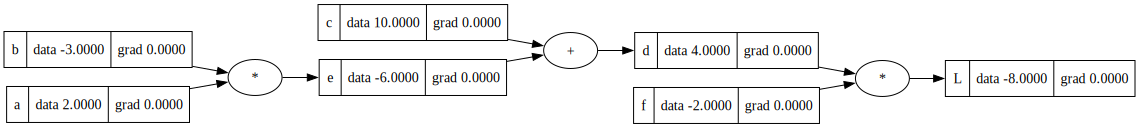

In [216]:
draw_dot(L) # visualizes the forward pass

In [217]:
# run backprop: start at end and calculate gradients of intermediate values

In [218]:
def scope():

    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L1 = L.data
    
    a = Value(2.0 + h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label = 'L'
    L2 = L.data
    
    print("dL/da:", (L2-L1)/h) # Estimating derivative of L wrt a

scope()
    

dL/da: 6.000000000021544


In [219]:
# inputs x1, x2, weights w1, w2, bias b
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.881373, label='b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


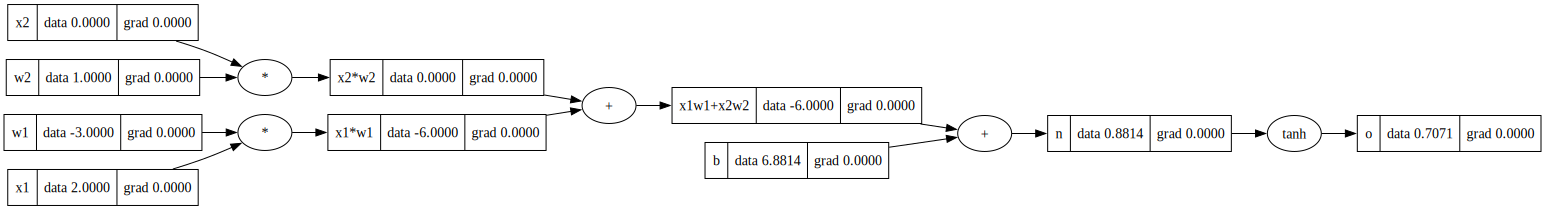

In [220]:
draw_dot(o)

In [221]:
o.grad = 1.0 # base case

In [222]:
o._backward() 

In [223]:
n._backward()

In [224]:
b._backward()

In [225]:
x1w1x2w2._backward()

In [226]:
x2w2._backward()
x1w1._backward()

In [227]:
# instead of manually calling backprop:

o.grad = 1.0

# topologically sort graph of nodes so that we can propagate gradients in the correct order
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)

build_topo(o)

for node in reversed(topo):
    node._backward()

In [228]:
o.backward()

---

In [229]:
# Same thing, but with pytorch
import torch

x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True
b = torch.tensor([6.881373]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # forward pass
o.backward() # backward pass

print('---')
print("x1.grad", x1.grad.item())
print("x2.grad", x2.grad.item())
print("w1.grad", w1.grad.item())
print("w2.grad", w2.grad.item())


0.7071064519863152
---
x1.grad -1.500001396677975
x2.grad 0.500000465559325
w1.grad 1.00000093111865
w2.grad 0.0


In [245]:
# Building a neural network

class Neuron:
    def __init__(self, nin): # nin = number of inputs
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
        
    def __call__(self, x):
        # w * x + b
        activation = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for n in self.neurons:
            params.extend(n.parameters())
        return params
        # or: return [p for n in self.neurons for p in n.parameters()]
    
class MLP:
    def __init__(self, nin, nouts): # nouts = list of number of outputs for each layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
            
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params
        # or: return [p for layer in self.layers for p in layer.parameters()]
    


In [282]:
x = [2.0,3.0,-1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x) # forward pass of mlp

Value(data=0.5437763373784186)

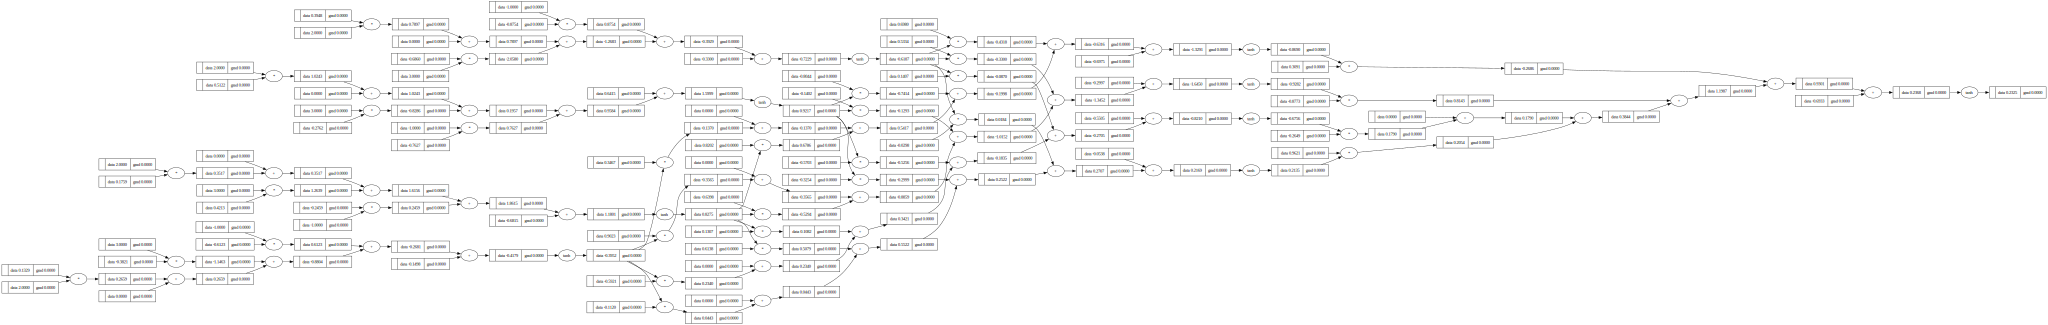

In [247]:
draw_dot(mlp(x)) # visualize forward pass

In [283]:
# small dataset
xs = [ 
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # labels



In [286]:
for k in range(20):

    # forward pass
    ypred = [mlp(x) for x in xs] 
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)]) # mean squared error loss
    
    # backward pass
    for p in mlp.parameters(): # reset gradients
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in mlp.parameters():
        p.data -= 0.1 * p.grad # gradient descent
        
    print(k, loss.data)

0 0.022115569348268194
1 0.020384088278263893
2 0.018905116367756127
3 0.017626965475593833
4 0.01651119729655992
5 0.015528622631805954
6 0.014656670770463214
7 0.0138776101524977
8 0.01317731483304357
9 0.012544390617680761
10 0.011969544008087087
11 0.011445118621157014
12 0.01096474935712243
13 0.01052310079771547
14 0.01011566680588256
15 0.00973861523093936
16 0.009388666290681712
17 0.0090629963988008
18 0.008759161429917466
19 0.008475034984098394


In [281]:
ypred

[Value(data=0.9917081377421209),
 Value(data=-0.9988331017831981),
 Value(data=-0.999917168228037),
 Value(data=0.9892372987675947)]

In [252]:
mlp.layers[0].neurons[0].w[0].grad # gradient of first weight of first neuron in first layer

1.5444892239494745

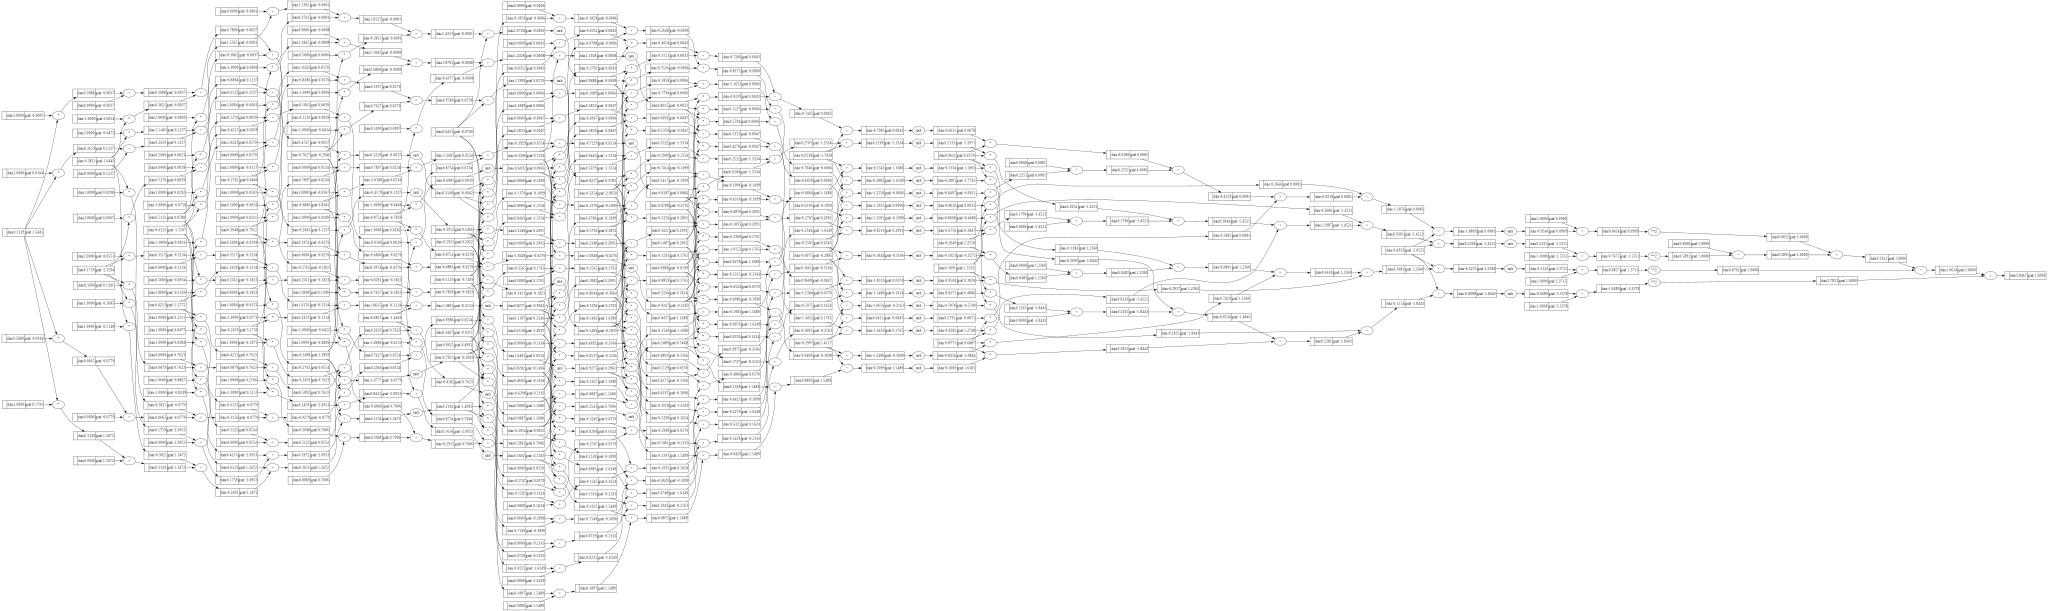

In [253]:
draw_dot(loss) # visualize backward pass

In [254]:
len(mlp.parameters()) # number of parameters in mlp

41

In [256]:
mlp.layers[0].neurons[0].w[0].grad # gradient of first weight of first neuron in first layer

1.5444892239494745

In [272]:
mlp.layers[0].neurons[0].w[0].data

0.024812057131803122